<a href="https://colab.research.google.com/github/matsunagalab/tutorial_analyzingMDdata/blob/main/05_md_dimensionalreduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dimensional reduction

## MDTrajのインストール

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:26
🔁 Restarting kernel...


In [1]:
!conda install -c conda-forge mdtraj

Channels:
 - conda-forge
Platform: linux-64
Solving environment: / - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.7.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



## T4 LysozymeのMDデータの取得

比較のために wildtype と mutant 関連のデータをダウンロードする。

In [2]:
!gdown 1Lu22Z7ARKSws77sBaYr84iCcQsnTHId9
!gdown 1Eh0SSSxgAmv7LI2NvAY43tLMLI63lSa-

!gdown 1Lwx8zhPSBMApi94QZtpLW7pMUzj2wDhv
!gdown 1EdM1H1C3CwA2vH7E4-59jrqQB6kQkYek

Downloading...
From: https://drive.google.com/uc?id=1Lu22Z7ARKSws77sBaYr84iCcQsnTHId9
To: /content/wildtype.pdb
100% 214k/214k [00:00<00:00, 79.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1Eh0SSSxgAmv7LI2NvAY43tLMLI63lSa-
From (redirected): https://drive.google.com/uc?id=1Eh0SSSxgAmv7LI2NvAY43tLMLI63lSa-&confirm=t&uuid=f8a8802f-f776-4f53-9ed2-48ee707ab337
To: /content/wildtype.dcd
100% 318M/318M [00:01<00:00, 169MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Lwx8zhPSBMApi94QZtpLW7pMUzj2wDhv
To: /content/mutant.pdb
100% 214k/214k [00:00<00:00, 77.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1EdM1H1C3CwA2vH7E4-59jrqQB6kQkYek
From (redirected): https://drive.google.com/uc?id=1EdM1H1C3CwA2vH7E4-59jrqQB6kQkYek&confirm=t&uuid=15be1625-bde1-49df-b2c6-d263dfc0e9bc
To: /content/mutant.dcd
100% 317M/317M [00:02<00:00, 123MB/s]


## Ca原子座標の主成分分析


In [15]:
import mdtraj as md
import numpy as np

w_ref = md.load('/content/wildtype.pdb')
w = md.load('/content/wildtype.dcd', top='/content/wildtype.pdb')

m_ref = md.load('/content/mutant.pdb')
m = md.load('/content/mutant.dcd', top='/content/mutant.pdb')

In [16]:
atoms_to_keep = [a.index for a in w.topology.atoms if a.name == 'CA']
w.restrict_atoms(atoms_to_keep)
w_ref.restrict_atoms(atoms_to_keep)

<mdtraj.Trajectory with 1 frames, 164 atoms, 164 residues, and unitcells at 0x7ff172713550>

In [17]:
atoms_to_keep = [a.index for a in m.topology.atoms if a.name == 'CA']
m.restrict_atoms(atoms_to_keep)
m_ref.restrict_atoms(atoms_to_keep)

<mdtraj.Trajectory with 1 frames, 164 atoms, 164 residues, and unitcells at 0x7ff17020ceb0>

In [18]:
traj = md.Trajectory(xyz=np.concatenate((w.xyz, m.xyz), axis=0), topology=w.topology)

In [19]:
traj.xyz.shape

(20000, 164, 3)

In [20]:
import copy
ref = copy.copy(traj[0])
for i in range(10):
    traj.superpose(ref)
    mean_xyz = np.mean(traj.xyz, axis=0, keepdims=True)
    print(np.square(np.sum((ref.xyz - mean_xyz)**2)))
    ref.xyz = mean_xyz

54.230873
5.0590445e-11
4.0825313e-19
6.439474e-20
7.7846724e-20
6.709503e-20
5.890629e-20
6.74744e-20
5.744589e-20
5.778724e-20


In [21]:
traj.superpose(ref, 0)

<mdtraj.Trajectory with 20000 frames, 164 atoms, 164 residues, without unitcells at 0x7ff170813310>

In [22]:
traj.xyz.shape

(20000, 164, 3)

In [23]:
coordinates = traj.xyz.reshape(traj.n_frames, traj.n_atoms*3)
coordinates.shape

(20000, 492)

In [24]:
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

pca = PCA()
pca_result = pca.fit_transform(coordinates)

Text(0.5, 1.0, 'PCA scatter plot')

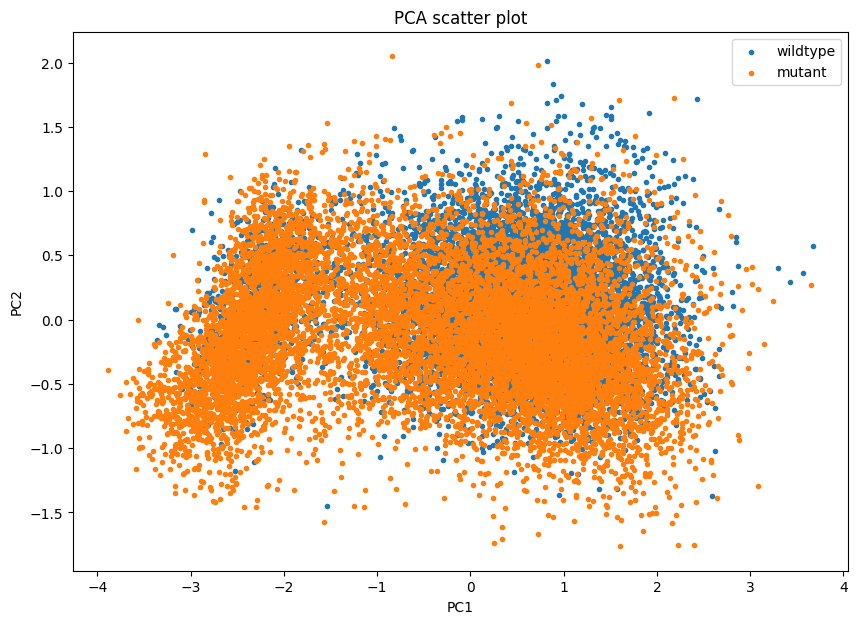

In [25]:
# Plot the first two principal components
plt.figure(figsize=(10, 7))
plt.scatter(x=pca_result[:w.n_frames, 0], marker='.', y=pca_result[:w.n_frames, 1], label="wildtype")
plt.scatter(x=pca_result[w.n_frames:, 0], marker='.', y=pca_result[w.n_frames:, 1], label="mutant")
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA scatter plot')

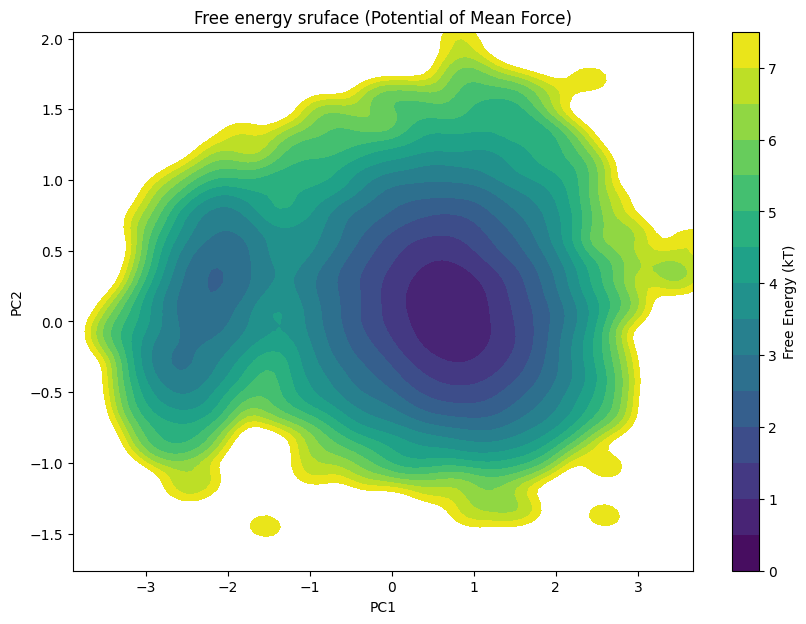

In [26]:
# Calculate the potential of mean force
kde = gaussian_kde(np.vstack([pca_result[:w.n_frames, 0], pca_result[:w.n_frames, 1]]))

# Compute the potential of mean force
x, y = np.mgrid[min(pca_result[:, 0]):max(pca_result[:, 0]):100j,
                min(pca_result[:, 1]):max(pca_result[:, 1]):100j]
positions = np.vstack([x.ravel(), y.ravel()])
pmf = np.reshape(kde(positions), x.shape)

# Plot the potential of mean force as contours on top of the scatter plot
plt.figure(figsize=(10, 7))
plt.contourf(x, y, -np.log(pmf), np.arange(0.0, 8.0, 0.5), cmap='viridis')
plt.colorbar(label='Free Energy (kT)')
plt.title('Free energy sruface (Wild-type)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


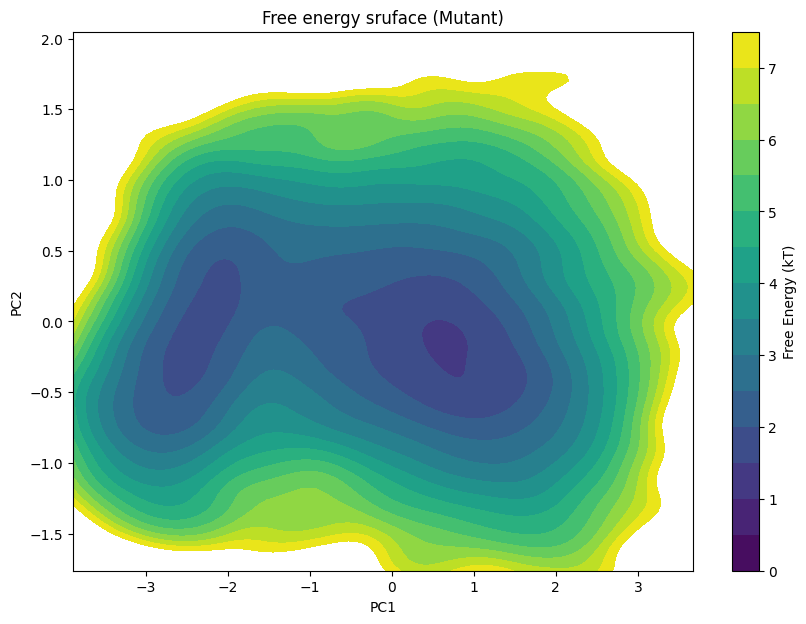

In [28]:
# Calculate the potential of mean force
kde = gaussian_kde(np.vstack([pca_result[w.n_frames:, 0], pca_result[w.n_frames:, 1]]))

# Compute the potential of mean force
x, y = np.mgrid[min(pca_result[:, 0]):max(pca_result[:, 0]):100j,
                min(pca_result[:, 1]):max(pca_result[:, 1]):100j]
positions = np.vstack([x.ravel(), y.ravel()])
pmf = np.reshape(kde(positions), x.shape)

# Plot the potential of mean force as contours on top of the scatter plot
plt.figure(figsize=(10, 7))
plt.contourf(x, y, -np.log(pmf), np.arange(0.0, 8.0, 0.5), cmap='viridis')
plt.colorbar(label='Free Energy (kT)')
plt.title('Free energy sruface (Mutant)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()